# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.
import random
import numpy as np
from comp411.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'comp411/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


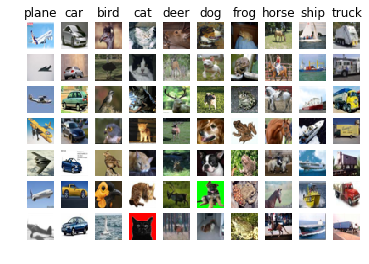

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


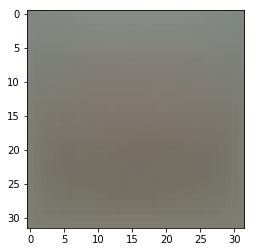

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [8]:
# Evaluate the naive implementation of the loss we provided for you:
from comp411.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 8.869944


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [9]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)
#print(loss,grad)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 33.018559 analytic: 33.024562, relative error: 9.089578e-05
numerical: -4.783171 analytic: -4.703204, relative error: 8.429673e-03
numerical: -28.934181 analytic: -28.934181, relative error: 6.135803e-12
numerical: -21.334515 analytic: -21.334515, relative error: 7.053383e-12
numerical: -17.088540 analytic: -17.068249, relative error: 5.940481e-04
numerical: 45.808337 analytic: 45.806364, relative error: 2.153585e-05
numerical: 11.533738 analytic: 11.532206, relative error: 6.641300e-05
numerical: 7.727097 analytic: 7.751484, relative error: 1.575569e-03
numerical: -26.118190 analytic: -26.118190, relative error: 1.339386e-11
numerical: 0.546488 analytic: 0.433661, relative error: 1.151122e-01
numerical: 28.186719 analytic: 28.186719, relative error: 2.577372e-12
numerical: 5.024168 analytic: 5.024168, relative error: 4.589054e-11
numerical: -38.136435 analytic: -38.136435, relative error: 7.503317e-12
numerical: -42.483727 analytic: -42.483727, relative error: 2.956321e-12


## Modified Huber Classifier

Your code for this section will all be written inside `comp411/classifiers/linear_svm.py`. 

The Modified Huber Loss implementaiton should be similar to SVM Hinge Loss.

In [10]:
# Now implement and Evaluate the naive implementation of the huber loss:
from comp411.classifiers.linear_svm import huber_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 0.824519


In [11]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = huber_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from comp411.gradient_check import grad_check_sparse
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = huber_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: huber_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 9.914062 analytic: 9.914070, relative error: 4.081219e-07
numerical: 1.527351 analytic: 1.527351, relative error: 2.057104e-11
numerical: -6.907963 analytic: -6.907853, relative error: 7.926554e-06
numerical: 5.006029 analytic: 4.978480, relative error: 2.759240e-03
numerical: -11.202638 analytic: -11.202649, relative error: 4.578833e-07
numerical: -17.571494 analytic: -17.571437, relative error: 1.610224e-06
numerical: -5.884345 analytic: -5.884548, relative error: 1.724896e-05
numerical: 4.055792 analytic: 4.055792, relative error: 4.547330e-13
numerical: -23.202734 analytic: -23.202692, relative error: 9.085452e-07
numerical: 4.918465 analytic: 4.918388, relative error: 7.907290e-06
numerical: -8.038002 analytic: -8.038002, relative error: 2.285418e-12
numerical: -11.966795 analytic: -11.966795, relative error: 1.966836e-13
numerical: -36.852734 analytic: -36.852696, relative error: 5.111845e-07
numerical: 2.931810 analytic: 2.931810, relative error: 6.150549e-12
numerica

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ The reason of the discrepancy is because the SVM loss function is not differentiable everywhere, but it is not a reason for concern since gradient descent is an iterative process and knowing it can occur, we can just skip the gradient calculation for that example and without  For example, at x=0, because of the max(0,x) component of the svm loss function, it is differentiable on x>0 and x<0, but undefined at exactly 0. When the gradient is calculated at the instance where the value is non-differentiable, a failed gradcheck match can occur. An SVM model wants the score of the correct class to be higher than the scores for other classes by at least the margin. Increasing delta value can decrease the probability of the outcome of the equation resulting in x=0, hence decreasing the probability of failed gracheck.

In [12]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.820667e+00 computed in 0.082002s
8.82066661255923
Vectorized loss: 8.820667e+00 computed in 0.009978s
difference: -0.000000


In [13]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.081303s
8.82066661255923
Vectorized loss and gradient: computed in 0.003787s
difference: 0.000000


In [14]:
# Next implement the function huber_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from comp411.classifiers.linear_svm import huber_loss_vectorized
tic = time.time()
loss_vectorized, _ = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 8.245188e-01 computed in 0.122992s
Vectorized loss: 8.245188e-01 computed in 0.003761s
difference: -0.000000


In [15]:
# Complete the implementation of huber_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = huber_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = huber_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.096342s
Vectorized loss and gradient: computed in 0.003458s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [16]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from comp411.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()

loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

1567.0298947843855
iteration 0 / 1500: loss 1567.029895
1548.4703750987896
1535.611460479309
1520.828595881351
1503.2884688944553
1487.77229203509
1472.3615544490945
1456.4424939240484
1444.100206051091
1428.3957542799692
1414.453949716731
1398.966377951575
1385.1177571415426
1372.6014827974727
1356.8754288083671
1345.8125589092842
1329.6561164012483
1317.524137565718
1303.9979307109588
1290.3889970649866
1278.2125414311345
1264.6666691604414
1251.5761981824203
1240.70469264356
1227.1341093822034
1214.049864145687
1202.9118803333356
1190.7885311492
1177.7511339338491
1165.981947704006
1154.871884286697
1144.7720675507273
1131.6684370127614
1121.481501156844
1110.6095474256363
1098.1191058943236
1087.3673467958122
1076.5775196183204
1064.7819929766824
1056.4065527060352
1043.4684242844512
1032.2369845102596
1023.0247135543225
1012.7167499816833
1003.5757906612621
993.3143236413266
982.3675328805983
973.6024542108695
963.1736958646826
954.504797303806
945.0251204101562
935.0384058716846


22.948017755476776
23.036489520350692
23.167288464453662
22.643764857492815
22.39726894026998
22.980070263193046
22.373646711567915
22.106001794135317
21.961959818995446
21.081583711591215
21.356230029715512
21.443780923106704
21.58021008537709
21.168021976596968
20.643706824045427
20.763661460181268
20.938854242064018
21.20797599986667
20.34909139933199
20.628266333109
20.670684587041844
19.78563435714291
20.331591741410485
19.72614331468366
19.262902213557098
20.320852466668747
19.7803386927369
18.964661298598973
19.206419474288836
19.117564074940535
18.632237472108756
18.97911154299746
17.920237999289988
18.485925066048406
18.630712389285538
18.20263461021887
17.917474827535255
18.12788005234964
18.12443635399081
17.778160708123167
17.66556480456262
17.30404150983418
17.809169634692168
17.077533003118567
16.923030596653426
16.772517915952474
17.0153728112439
16.46938145836533
16.343315707789213
16.18140596096095
16.684922660148267
16.415497253696458
16.108250384381567
15.93093536839

6.288148326515387
6.3366655205060916
6.205381506660222
6.221666202011727
5.589236740491599
5.990721291767334
5.860626307583777
6.038266708926084
5.74321260288564
6.286888735674807
5.361723381964099
6.109215015849593
6.090969372023634
5.767574123373876
5.960487183843441
6.313567053110397
5.59110218829652
5.937987245669643
5.849760984649738
6.286631449518108
6.285360526037473
5.958242322974488
5.265490508938814
5.9356419185670815
5.581789712057146
5.45281552926971
5.91795950207308
5.920387360332573
5.897082167444837
5.850749374895308
5.74303111715268
5.604718872569208
5.612744469997114
5.831604126607307
5.558204916864334
5.827512360949873
6.163134616725299
5.5101115564755245
5.144377404390853
6.048763623988485
5.341237356722386
6.171811803861882
5.77841839316653
5.764895382223688
6.39752219833247
6.055273174870766
5.732608103603075
6.2899354969292425
6.1878953087769455
6.1686972256599955
5.954148542312499
5.600977362215681
6.1820938761397075
6.191108384292632
6.3876322260528955
5.7638004

5.580125968281667
5.48805839220437
6.3072734471503535
5.401925483762518
6.087325281496175
6.071114125421904
5.800291353727792
5.563280986075303
6.067311406082827
5.460387094025961
5.899357678918117
5.888250508253004
6.373621203521753
6.037062597736508
6.149289700259544
5.593488205336761
5.656540148903897
6.034796784738732
6.1467205295519065
6.408297057547808
5.744368711243589
5.830376535123324
5.986080132005622
5.648880515609098
6.057078085661463
5.596761701423307
5.412990517150101
5.7871164749385136
5.5880065583410765
5.996808151115581
5.507589383749614
5.877627277363737
5.350157693959178
5.19760527307758
6.111635147290978
5.744646984592789
5.709278298585406
6.359938235759385
5.974709299063889
5.209935072956728
6.059382564491164
5.496496614789816
5.768890072339821
6.230126851512295
5.6692881681709455
6.096486919524991
5.424795686292533
5.753290103592738
5.88313247404028
5.817684634607975
5.7442529658497
5.767800899241741
5.218533240145071
5.844094548464971
6.181754536789532
4.95794377

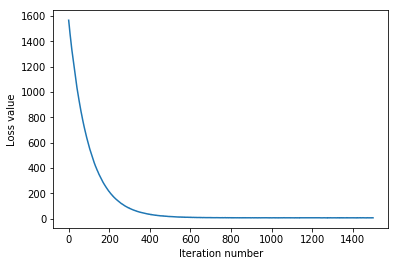

In [17]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [18]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370020
validation accuracy: 0.361000


### Stochastic Gradient Descent
We also have vectorized and efficient expressions for the huber loss, the gradient and our gradient matches the numerical gradient. Thus, we are also ready to do SGD to minimize the huber loss.

In [19]:
from comp411.classifiers import LinearHuber
huber = LinearHuber()
tic = time.time()

loss_hist = huber.train(X_train, y_train, learning_rate=3e-7, reg=0,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 13.825716
iteration 100 / 1500: loss 4.618653
iteration 200 / 1500: loss 3.589212
iteration 300 / 1500: loss 3.013791
iteration 400 / 1500: loss 3.483087
iteration 500 / 1500: loss 2.939511
iteration 600 / 1500: loss 3.175791
iteration 700 / 1500: loss 2.300746
iteration 800 / 1500: loss 2.355323
iteration 900 / 1500: loss 2.767871
iteration 1000 / 1500: loss 1.983084
iteration 1100 / 1500: loss 1.951365
iteration 1200 / 1500: loss 1.544139
iteration 1300 / 1500: loss 1.800542
iteration 1400 / 1500: loss 1.764581
That took 3.614792s


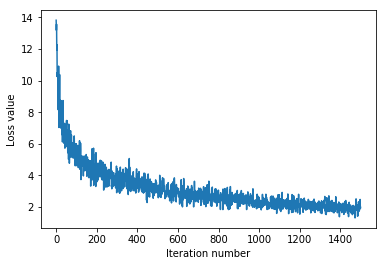

In [20]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [21]:
# Lets evaluate the performance on both the
# training and validation set
y_train_pred = huber.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = huber.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

## at minumim, you should see accuracy results around 0.25

training accuracy: 0.268918
validation accuracy: 0.258000


In [22]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate) and loss type (svm hinge or modified huber). You should experiment
# with different ranges for the learning rates and regularization strengths and cases
# for the loss type. If you are careful you should be able to
# get a classification accuracy of about 0.39 or higher on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug however you may want to add 
# safety margins for possible overflow/underflow causing operations in your .py implementations.

#Note: you may want to observe the behavioral differences between standard
#      svm hinge loss and modified huber loss

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength, loss_type) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best = None #  The LinearSVM or LinearHuber object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        
# Write code that chooses the best hyperparameters by tuning on the validation 
# set. For each combination of hyperparameters, train a linear SVM and a linear
# Huber on the training set, compute their accuracy on the training and 
# validation sets, and store these numbers in the results dictionary. In 
# addition, store the best validation accuracy in best_val and the LinearSVM 
# or LinearHuber object that achieves this, accuracy in best.    
#                                
#                                                                              
# Hint: You should use a small value for num_iters as you develop your         
# validation code so that the SVMs don't take much time to train; once you are 
# confident that your validation code works, you should rerun the validation   
# code with a larger value for num_iters.                                      
################################################################################

# Provided as a reference. You may or may not want to change these hyperparameters
learning_rates = [1e-7, 5e-7,1e-6,5e-6,1e-5]
regularization_strengths = [1e4,2e4,3e4,4e4,5e4]
loss_types = ["SVM", "Huber"]


# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

for learning_rate in learning_rates:
    for regularization_strength in regularization_strengths:
        for loss_type in loss_types:
            if loss_type == "SVM":
                classifier = LinearSVM()
            else:
                classifier = LinearHuber()
            
            classifier.train(X=X_train,y=y_train,learning_rate=learning_rate,reg=regularization_strength,num_iters=1500)
            validation_y_pred = classifier.predict(X_val)
            validation_num_correct = np.sum(validation_y_pred == y_val)
            validation_accuracy = float(validation_num_correct) / len(validation_y_pred)

            y_train_pred = classifier.predict(X_train)
            training_num_correct = np.sum(y_train_pred == y_train)
            training_accuracy = float(training_num_correct) / len(y_train_pred)

            results[(learning_rate,regularization_strength,loss_type)] = (training_accuracy,validation_accuracy)

            if best_val < validation_accuracy:
                best_val = validation_accuracy
                best = classifier

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg, lt in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg, lt)]
    print('lr %e reg %e type %s train accuracy: %f val accuracy: %f' % (
                lr, reg, lt, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

626.1327191608243
625.834214788022
623.73967730851
621.8066198990431
616.8026269135636
614.7803399329605
611.537744768317
608.4423682954155
605.1387684226027
604.9892602921138
600.9340802703329
598.5318262823249
595.9657267020382
593.6091623070504
593.7584332825692
588.4539644563985
586.4586884691423
583.692653939894
581.7967552028201
578.8288201364096
575.5307729032886
574.8624629439282
572.0456487709623
569.1463418000317
566.7901304903125
563.3611885684039
562.6622836110541
559.1564563333415
558.8795657638304
556.0997560239286
554.1842774802649
550.3615738494656
547.0199858167327
545.9698481634149
543.8135148922129
542.4728915628268
539.1589053952076
536.3023268301555
535.2322243789912
535.2037917548776
530.2752394495039
527.7025706013342
526.1574177740562
524.3703483435008
520.9891358589074
520.5828402425464
518.0476464868874
514.8424685779393
513.1427339415018
511.85462247663463
509.6855394166242
508.4105524681261
505.10159565202804
503.5684584887744
501.1706561365754
498.543775154

103.07605777735725
103.01726493538443
102.07499514224209
102.34741240107587
101.60503248991016
101.22021892255769
102.00552373024806
100.09751147327172
99.69847967096021
99.36617430663148
99.51135950464275
98.79865683190866
98.05297502818713
98.00081495148207
97.63383311415893
98.0361864299794
97.23259856472788
97.05205219872335
95.90834686637093
96.02555109473246
94.96486960380759
95.25709705059168
95.13661368727888
94.60383831250334
94.99686681252862
93.98756452875216
94.20249970898502
93.34720625237114
93.04413215787355
92.3763136032974
91.82980089521455
91.72016864376525
91.04034242966063
90.91890681914518
90.26432926349574
90.04476957650103
89.50877837216196
89.35258359562347
89.33243078304488
88.58017750009887
88.13001658165419
88.43497759454681
87.56450255500508
87.88184746329905
87.46536861265457
87.20571750756434
86.62974397402587
86.18188799645695
86.3294304262091
85.59748619821727
84.55780980997581
85.27980530451639
84.8266414062046
84.06101217212631
84.60676652742008
84.339

20.423915227819638
19.775389196686056
20.13822907402369
19.726707219302895
19.258542636525792
19.95479217649217
19.099953877262685
19.805457815246804
19.866416758773664
19.59326646376939
19.97298396069727
19.893747112585974
19.394114294896497
19.235889825053416
19.283017437239565
18.99521988803637
19.070699141137535
19.082839231981673
19.46324920851358
18.392933648681108
19.29061379714726
18.61713245471669
19.363383456615434
18.253613086228235
18.721269164548932
18.75874428279824
18.22924222759833
18.8348327188598
18.697341927655067
18.939967591554037
18.373262382360014
17.69428709041188
18.574108425674964
18.328996381200696
18.601444693877212
18.40985997034195
17.924618714642044
17.993874634316207
18.351060918435735
18.179894055616025
17.80095872346144
18.27221242359859
18.071005292065486
18.052375789922294
18.027092628353067
18.029337933584447
18.08326673911571
17.873062930777586
18.24237532228178
16.93186595593964
17.452922920565936
17.453627876248948
17.809900834200675
17.465882575

6.7441219058634765
6.713421317559019
6.968971954397309
7.321541064072241
7.003978060246148
6.4191023907356355
7.2525660405849415
7.695770973265857
7.043565461141609
6.268138031303676
6.988998144194571
6.902086733813018
7.342167737125935
7.382195373086431
6.76272652881765
7.317554579806076
6.554278832918463
7.578023437801023
7.007218877498035
6.703043516973081
6.774667177202196
7.220098776397226
6.975426785680337
6.788766341225985
6.690223728943542
7.180393698086516
7.158179961948263
6.755386253088107
6.691612284411882
6.402769553680979
6.6407186762394135
6.680937992301789
7.212868726374678
6.846938289944786
6.391473929887501
7.018362710112604
7.054250483091172
6.675443392627248
6.936807311099227
6.440139878628651
6.948383140830649
7.017789113519163
7.68229358627574
7.451135736446764
6.753779092280258
6.946061823474599
7.20041657529878
6.902062018253255
7.008895856801209
6.732339548911431
6.770014650032441
6.937627713959847
6.888724469391337
6.892760884921243
6.406173817429865
6.7123328

46.68742563283474
46.14970322592789
45.99355346593357
46.14008583147124
45.29424011917482
44.65254422949577
45.018001659938086
44.05296851561202
44.464923251898476
43.803369334533016
43.24426345659404
43.152529294833286
42.47513531570696
42.35066924801883
42.314877280349684
41.647219572171664
41.35907070341885
40.84520784448495
40.65892720432065
40.92214235955563
39.9846888733715
40.261517053895936
39.881303532011636
39.28519798787367
39.18600404015652
38.723653497157166
38.58172645868484
38.86353911294538
38.25538030915082
38.28390967344589
38.15166749903735
37.701588372526
37.103929285533816
37.087758533933346
37.031097356007095
36.525722006633174
36.220979573933924
36.02818963902692
36.090097722720905
35.28489031200272
35.585062502095866
34.797115745891844
34.49547272929285
34.79499327827445
33.98501110282062
33.91650577023956
33.88006147269405
33.30712027366901
33.19748296093432
32.58888164890328
32.86757906771446
33.13200354184956
32.09318665995801
32.47776701009491
32.56675817191

6.797195445575094
6.166272623959642
5.804376179776948
6.313071429801354
5.880492410087889
5.930643143928664
7.201849504900835
6.909707792902059
6.232094575824803
6.035737515212816
5.590876157359947
6.113952099806494
6.368809565650837
6.860471768178332
6.812954219710434
6.524606664794584
5.949311916807508
6.7100457936183275
5.822508492902893
5.884136709674633
6.150839681555637
6.48076625662984
6.496360547543785
6.5778785246927285
6.396704036274822
5.656730968285585
5.541361365567161
6.29383546732644
5.731725048379291
6.463309996639364
5.698714863293608
5.847409402309935
5.656660079970724
6.9970696524672045
6.04032271849488
5.848684030989847
5.901983998062168
6.264431563752274
5.9489560603008504
6.076698569265767
6.3561469592866
6.126758188163223
5.855896177151188
5.889805153752952
5.951671065141239
5.936852023346835
6.191633580537523
5.544870673330966
5.5147926592868295
6.50143016816322
6.348828102640908
5.35378188579376
6.393911654500651
6.187004733705338
5.8542632152805005
6.130797432

4.926113533319285
5.192507249302642
5.492901284635817
5.631485813211971
5.909350487876315
5.420044894905397
5.9828297209666506
6.34579267123432
5.697407606678024
5.216658157376969
5.570624147940922
5.959216450073127
5.397530761176958
5.703201632134472
5.7701398038940095
5.585908199153558
6.368875354429905
6.0408880285877675
5.77281634704158
5.582362008038082
5.4366867999638036
5.808683890582199
5.491559283103335
5.796812422510084
6.349406114207833
5.430748223119733
5.643720994109022
5.155315730842552
5.8495717881221765
5.680877108491417
5.4076815953564
5.6513456091267855
5.63264957123245
6.175985054738003
5.464797686715793
6.230407102868181
5.448594887451465
5.7898495915426205
5.782642419577635
5.553037718644307
5.884449808254488
5.64475277826154
5.800836301610398
5.6911436751198
5.529003010581578
5.3608301646849394
5.90056233746729
6.189474257379524
6.19602079752578
5.349320345797711
5.404815545502338
5.646194903146926
5.627019413854988
5.447007910245554
5.954200801373792
5.8129370478

16.067975371548314
15.889074416740428
15.513807658631066
15.317429564442527
15.544130545042753
15.281608801758898
14.63044513042788
15.206815802759866
15.41557436564337
15.298779190898259
14.984885217589479
14.709263859808974
14.357456269470607
14.796518793824692
13.710957014506976
14.856264547829003
14.530513271475407
14.035561420391371
14.192189162180624
13.673263228547956
14.147473745795761
13.70529939793252
13.53377542114724
13.698191837860922
13.161032040569944
13.418519286989378
13.36511362105731
12.484589488979083
13.162815991075291
13.303153319800602
12.8678826141754
12.64230692102909
12.97232639436767
12.557771679842897
12.61025464069046
12.825060054385354
12.227095718385861
12.408118474799139
12.200004854696246
11.76633579310124
11.780530204733683
11.750947556386588
11.92504421939581
11.999272643387368
11.357242326792473
12.031919729985388
11.637725252367577
11.762364661595313
11.486078483009244
11.299217537954615
10.77865276204533
11.16439108511437
11.377229598298324
10.7779

5.988774159502272
5.7825308389925
5.7241922104925935
5.752484956755588
5.922815508375124
6.316625555201921
6.045432140458233
5.889920752145394
5.877019296339227
5.8620527863616285
5.772499134372051
6.256853935290546
5.479263743345392
5.814875672143678
6.022844612328468
5.945270170931888
6.07739394069262
5.557059941884698
6.3150409317348535
5.826227971036534
6.334788251964585
6.07387595820158
6.122750375362517
5.3956935527780265
6.179958030091256
5.6397691968757835
5.307996115603532
5.700962042351175
6.344696212172144
6.0496084356592315
5.8307838812441375
6.339722782885009
5.751254649813338
5.995013204325054
5.718221498861671
5.596772914078931
6.277915492856213
5.9931498515099655
5.995586781235589
6.339841905223872
5.769967530381303
5.835257768527346
5.789967299705203
5.595069672149401
6.204983921510151
5.988903287202195
5.907456450886359
5.632872933085203
5.984866438434085
5.581232509019599
6.159942732735731
5.358922904690978
5.509598715444228
6.1178413791575235
5.549159848544476
6.062

6.265130835573667
6.00739129895867
5.709773769865232
5.98060561094393
6.2759865781402375
5.820071004174794
6.630235424950173
5.992681145093048
5.937108499841749
5.833164182974905
5.574906534405794
5.867867963712458
6.00113422824679
6.205278736922913
5.667689178667011
5.781269085556767
5.421050571507011
6.1403702197961225
6.107634222784904
6.139125262352358
6.046223971237585
6.342641858055635
5.951940473353641
5.850426532792748
5.832083128370178
6.22156539849518
5.748846800354321
6.248376344688757
5.654006519063476
6.343805886041507
6.152434649057181
5.955503929303954
5.898782113697944
5.810379795891356
6.023400447012809
5.853328572238016
5.796490631349292
6.438719162153406
5.464604870075778
6.148316040184995
6.403080689718501
5.798480849864161
6.36115900874505
6.5366291008873105
6.339339574873643
5.781189305147071
6.059292168876381
5.808828009802702
5.940041129391535
5.65345448623614
5.967090722319279
2504.536361412277
2467.303964091523
2427.519148637361
2387.512692936608
2347.34935703

8.635303718134406
8.04385832778209
8.552018289139953
8.19927562810213
8.070028422282197
8.325044735701812
8.300887969424696
8.84650962629388
8.352503450378016
7.992992051732822
7.681353539708855
8.368442531457159
7.636155440154423
8.013156321696744
8.194640723049215
7.436399267987727
7.8881439835774305
7.830149550025042
7.9693346277233
7.8681836868637784
7.414895179532071
7.848202833324079
7.141967338164982
7.82764589806756
7.361441041883379
7.582613510350212
8.255171308652532
7.755899813650084
6.999181085042409
7.708904657519528
7.9559122877926365
7.704036225001001
7.082385518909348
7.5809174175997835
7.676959828433137
7.689058274736167
7.368570301975483
7.236784784315118
7.474944915794208
7.6901205280315965
6.996304613252432
7.20047794334979
7.569742374893161
7.196127369812842
7.119529440141504
7.03453779025252
7.185491809979611
6.831216768462312
6.71224069731752
6.638590500270018
7.07775673619983
7.46170411768597
6.583290690783706
6.895027547573697
6.783581803478858
7.06767905053065

6.487786284973437
6.029189683191263
5.783969503051557
6.270664581890429
6.022954266713053
5.710614817651959
6.428607020955038
6.184857180068546
6.082624490927695
6.33598599369143
6.155610409028633
6.197042443874953
6.281667056720001
6.117095031931537
6.483116800648449
6.244610849809851
6.010477411421307
6.657206431210946
6.008994935498633
5.818128063607238
5.7400449801588795
6.014204021564177
5.8404028433926625
6.423812655855581
6.334626363929399
6.389254668730108
6.388985370370412
5.931943364204969
6.1969386020492525
5.6733859765597225
5.636844999583865
6.476521102576809
5.7848178682433575
5.761075996940355
6.010507861062265
5.606789989095237
6.108434764002168
6.107623637200889
6.016594443485088
5.803664112616668
6.154214912149828
5.911869972058951
5.9365408657589
6.046060627310919
5.961848294589205
5.990177402490987
5.5985926975000115
6.151980110603899
5.8425734661649615
6.025051353008101
6.339047446993429
6.018265995419738
6.348214593584912
6.109589566922757
6.1261903362273165
5.897

5.716391777016439
6.234802156573768
6.401473867515416
6.12394585681393
6.284425631963742
5.494585769464241
6.115885189268708
5.946087485089149
6.391144133471641
6.39890840403879
6.3607277799457265
6.147023007407256
6.265515470307879
5.803776873894962
6.083905332473624
6.450798585198132
6.000867486527888
5.90542033697619
6.339387016454839
6.208723571561322
6.43379130777312
5.372583601889364
5.789055893707609
6.172452888484724
5.846378238900122
6.398947098379389
5.707037772644868
5.828910410116592
5.969439544679803
5.970058612216253
6.184920791655437
6.105785110623661
5.362393488428205
5.572418826935409
6.356216858574522
6.2762683865521565
5.766436953431625
6.1118772786620275
6.159148237645918
5.575941099498074
5.831320676471222
6.230798320877275
5.857778256194923
6.136453682072005
6.723652993183135
6.40375413063516
6.493202998225329
5.981580967434956
5.7795306771790385
6.043425504164727
5.657941332515276
5.799063318347875
5.516693485421165
6.384157596144345
6.205073175573192
5.837968151

9.607165415765099
9.367270944024401
9.461983627652938
9.363579854205689
9.481271373764423
9.1603452034362
9.498809273380171
9.684775718531656
8.939926677592318
9.067827195844629
9.664783695014933
9.006120382690536
8.70792705221855
8.856516241973319
8.603236900094906
9.156954254324688
8.159535101890814
8.543826029096955
8.792574347160208
8.001765714295482
8.669871017573348
8.90018265492924
8.5283883977585
8.376708223802595
8.219457907664848
8.363311313368978
8.473510109659156
8.160549149528743
7.957151482818323
8.083512402714064
7.743797069311004
8.178965933031694
8.146952727329175
8.262115042040556
8.490497778537417
7.905932952190311
7.949873480520624
7.633832104702216
7.917365616896367
7.343338761085516
8.07034158334562
7.948684085090646
7.5213591652242915
7.801543047600392
7.779631928504649
7.735187502948705
6.9896121723588
7.913604721126326
8.085310207156144
7.815689553616167
7.223557085828413
7.399652738408522
7.414056025256924
6.791688987994706
7.517852188671404
7.233081508745649


6.417847433091699
6.005284317321446
6.440618581914646
5.756036146478973
6.071785059376709
6.448302514440693
6.436087764726623
6.146131104706283
6.48655522883822
6.305553482656625
6.091113358603893
6.399875773055863
6.3409748054413
6.3827917650195705
6.301820829851239
6.406541142084053
6.817258344210931
6.498889914592214
6.2661509721543265
6.406326405156651
6.1061434303131445
6.37764884273842
6.170566260052852
6.546522097944535
6.2324603376128564
6.366244858078217
6.049191861456906
6.380700216012979
5.762446421942949
6.125112155346313
6.033974942198092
6.04560693501022
6.32737530878625
6.251807479593548
6.078111464240574
6.0144009678308175
5.960198236953929
6.3269734707500955
6.568685588869885
6.024235164195099
6.212367319196022
6.5045681489221785
6.544266032568366
6.128821389683514
6.276645246482785
5.502269456669719
6.115344041639727
5.911887556583459
6.369292234297255
6.417833215094541
6.14719137688355
6.062016339627822
6.486887313047447
6.401960525807616
6.154206824008846
5.95298022

6.0203880179874
6.626342470314749
6.171490598684949
6.2104880948520265
6.396202895774207
5.994579955569263
6.58580784866195
6.287209331055555
6.372371639062171
6.148633541045895
5.984362601721507
6.110231629731226
6.083130633205514
6.133584363081436
6.385749887124913
5.990848481175648
6.07997111109495
6.184682759805412
6.492633834568666
6.173935154471519
6.601975918092257
5.873782767279666
6.440061821738702
5.752481173574772
5.674907192533427
6.6454931591884785
6.212030067111229
6.330238605659009
6.54726197947438
6.379102903263135
6.060392135293832
6.051237624961832
6.511910324407705
6.178046444835552
5.7919519218020605
6.0423687195743465
6.347535765137649
5.903056291004011
6.26544289993829
6.755263868169562
5.957369755646734
5.969109878263849
5.75629094708556
6.248426241303885
6.369109664649457
6.2686245594009815
5.933878981064002
6.537015283793546
6.130409506550479
6.293817946058024
6.148573005983799
6.381810256691503
5.842303505216245
6.230268825370647
6.314281991373615
6.6168350463

6.297417181089386
6.685475083003745
6.080466102613222
6.46967439000793
6.912878685614674
6.08697487908552
6.436024010599901
6.342114373160476
6.341552888468916
5.849329920943659
6.43533049997616
6.511325118172485
6.221506789119023
6.776646209283545
6.23394787099137
6.784889881364931
6.311788183478074
6.103891124480839
6.448334313882894
6.338122702575237
6.423797380778227
5.778569385230286
5.734587399678307
6.015281732773085
6.492675161547783
6.565436422947914
6.3151407329579445
6.605953297591606
6.066761353318955
6.099299908940028
6.79650364371416
5.960886045526789
6.131498546837474
6.073199814089579
6.415042838661602
5.958981197044952
6.08687265952211
5.780895616200446
6.006864453186306
5.906087596136135
5.852204747618867
6.182764123036997
5.849015317985939
5.926120874575966
6.591928397201507
5.926489410423209
6.1951932972938
6.540473670072446
6.215232371212053
6.2866171851878585
5.967605805134022
6.028530915884218
5.898462570869569
5.818696471245882
6.295676923483002
6.65500014931523

6.317405446929035
6.101592083258757
5.056374721191222
5.64842187890067
6.2582272755072905
5.762696464966369
5.905061599322302
5.564366043822463
5.830724974597491
5.985977591524459
6.028130229892065
5.666472833796281
5.803997348710755
5.198024855238734
5.939417695164183
5.8694044929258204
5.387693105333599
5.3643321148029
5.249524104569191
5.9352074537151935
5.854315628225154
5.268480565911491
5.999005222223863
5.823229102951217
5.62496116208866
5.849183619125062
5.7156181716759304
6.086307309594903
5.37129251894711
5.773358333681825
5.6699076048700325
5.933139814846076
5.867080847687878
6.269899680372173
5.738606781200279
6.139597074055885
6.14838560181949
5.512930172621358
6.086056643169107
6.0208780841671725
5.846697045094419
5.120369242488336
5.7727910122917
5.554079854282193
5.389544794178447
5.984752977176206
5.313891514347857
6.020893840546071
6.1160106224809745
5.819443092392283
5.314278998212396
5.3722144557542375
5.868967069023897
6.3577323054942
5.955753732940034
5.9853538434

5.791698688255353
5.331829041615171
5.841863550044821
5.176294129314946
5.707860314886136
6.337378613910577
6.506349135667088
6.355004106966334
6.0344887461720065
5.9659890775491045
6.525391145339899
5.781525467097907
6.057269274791728
5.493416638591405
4.97099480568706
5.715302185658541
5.78202629511687
5.320367607650213
5.381946766058116
6.009545867385018
5.710357759481872
5.50483656385992
5.309683659010859
6.175244662216209
5.269540651626399
5.971281378653988
5.183868871200439
5.398019559401427
6.1253213989462
5.50962153355829
5.537250062901281
5.1254861880661275
5.895254298104298
5.956769493827369
6.373009547197063
5.801945015766529
6.022651945180703
5.855043514430741
5.938169733833318
5.625537701135915
5.917805372525915
6.066321925673003
5.689333052487461
5.763232431984684
6.224381571120983
5.840120538520457
5.529422953477916
6.176703739420716
5.667668122799118
5.413559640421307
5.406284472746764
5.74059886432346
5.910155354765349
5.018699623913914
5.431895381768225
5.600970779363

6.2175112473122685
5.927972684191536
6.122736516441733
5.610078546230997
5.931371849705841
6.01689608936702
6.1271654196673655
5.737841752646848
6.330052086020508
6.205422922617067
5.889769402407195
5.53028618699116
6.75191356915405
5.935794403708921
5.151552366705459
6.756193925066642
5.986307591772514
6.4092628515996175
6.6199405073301705
5.95514444902333
6.34714789395002
6.565358127978317
6.013430042068803
6.308112547351303
6.365547418464347
6.005518672060023
5.78454959312351
5.845150170883949
6.248800286449839
6.138420134835396
5.871982498877846
6.190759585666093
6.27413211539965
5.383356609872031
5.940240752529275
6.671251684142378
5.9664007009593
5.958203419407689
5.783454769817786
6.266624764846149
6.46113928208343
6.2727801054218295
5.895223425177962
6.147707487489347
5.432206928540112
5.8005902348453455
5.793930694651987
5.814106721664698
6.688763636667994
6.629592246859915
6.357444761459319
6.3816305925987855
6.477666568585277
6.649473471709234
6.335347451187413
6.18009974986

6.071215916442532
5.839877179096854
5.579291017367431
5.213835790882434
6.040709442069975
6.483769171601292
6.012089272683754
6.451508835954857
5.710960708258776
5.883899235059546
5.884040089301864
5.7733123837664
6.013874496990358
7.171681915373608
6.172250413516593
6.049805515129113
5.674485403802937
6.2130597497732705
5.835837517106575
6.162574360375701
6.684318193302969
5.766933352015789
6.033116840656076
6.813093233883686
6.286753032430891
5.960199217169756
6.013535390176884
6.226871036277263
6.228931685754565
6.040835633671356
6.299773378075068
5.6928114909311605
6.483492241788719
6.726246164285441
5.832586834055779
5.962965493902891
6.226185257776642
6.171998768086368
5.670126035418372
6.104548984115024
6.505068085125524
6.44019550767673
5.797307287135519
6.263122205277558
6.167468909275207
5.735301617887159
6.03938787659419
5.841690376786348
6.3806087080745595
5.843801819514248
6.288788928108516
5.463549083036631
6.744107855311887
6.2448676635119895
6.34371466954706
5.766611172

1875.3425888716138
1760.2918234818717
1658.8571042701567
1558.6934919559933
1463.9412939610709
1376.2986742881812
1295.6931115074772
1219.8412164717693
1147.6836536346766
1079.6381569350444
1014.5763169360375
956.4637603658794
899.3497621554104
845.3966721420283
795.9124812447229
748.5213239098077
704.1298472050298
663.0313458953218
623.8645048972223
585.8618614784781
551.277184760306
519.8279502534043
489.9963051747651
460.0081318449113
433.82686441715146
408.3125461408075
384.3473304807034
360.9037106071268
341.0072485251059
321.1941311505199
301.6797613682469
283.76338362663313
267.56517128804444
252.7646918768864
237.83758806878754
223.52811554189384
210.40275990446787
198.2895293885348
188.49870156864796
175.78222989974844
166.9923461122305
156.18729580357603
147.95863862942312
139.4723963004432
131.89435868642957
123.72110344507368
116.70620811372078
109.77360589589085
104.14985504661686
98.89996056836152
93.26772894881954
87.3424919181183
83.0412944490555
78.58968927515286
73.97

6.214802019212795
6.750603616927476
6.541411695756613
6.663130989038197
6.242637063801563
5.980812963489359
6.240192645828076
6.080653717221235
6.70927631282491
5.853914388809319
6.504756823753905
6.028788091964306
5.94253608571276
6.467889322567627
6.474652974342385
6.572514232437907
6.901522800094278
6.029162742859624
6.2244313981890365
7.152657561193754
6.0069680457506385
6.692897084219156
6.339176582990377
6.455537909672373
6.068841194258977
6.609253971011391
6.038788076225471
6.3019721920444
6.210825346413132
6.798948545294291
6.860007401901317
6.330693203057112
6.367947714639756
6.211571218111211
6.866161798241409
6.2443132914696635
5.8412478441574605
6.4670591316792745
5.91294290500196
6.505824437593983
6.656571694377267
5.673386227095499
6.826939067879563
6.477883395026769
6.4602709289262314
6.229121362126715
6.621218028019635
6.624603239187088
6.322531575286213
6.491688327638025
6.997482649228288
6.400808534854886
6.417786418266125
6.595842038156532
6.262056884143119
6.4014924

5.8096100506285815
6.4901986145626225
6.4212591065298685
6.380051226617124
7.001213972046832
6.609829139952659
6.534960582968729
6.427947427707334
6.235682639422
6.536645139456459
5.913928611035271
6.15774943994618
5.859903950600353
6.053215082397445
5.960644840479596
6.895739184936576
6.6191930831267545
6.874345837324647
6.125835123895232
6.379450385356849
5.908589916412318
6.600930755588021
6.0189441139183915
6.041069520431074
6.141733319449655
6.9111805755575455
6.730170477293561
6.5336174571385595
6.582717927611149
6.5127882675662825
6.773506981560603
6.823734950520413
6.195785914267599
6.869473225222859
6.055701658747352
7.260268381450921
6.384352480043827
6.287689939054134
5.918109724176933
6.3237401505480015
6.894930389546323
6.2342519942397265
6.383876728479536
6.061671547391649
6.486969161926053
5.9026873057475635
6.423708970566947
6.428114783125597
6.289438021563713
6.095984402354542
6.754240287476975
6.792521335672315
6.139864929029714
5.8999469576775905
6.702082920479446
6.

2515.8980652135283
2310.87183555448
2129.5847400323123
1960.548533050334
1806.2385008553624
1663.8416310551765
1531.7000928492625
1411.7623929735948
1300.1636835273641
1198.4775394534192
1105.253385603561
1018.2343032824109
937.7809072637847
863.6622752285624
797.4634841036127
734.823952325094
676.8306430135162
625.1397279294696
575.6030315526325
531.027123881253
489.91036269422995
451.90222202432807
416.06130211945896
383.47079278141433
353.79116307868867
326.98632582847836
301.3196759485562
279.0736313038087
256.4113998146415
236.44389354184955
218.4440262109967
201.81907812903097
187.43634696040903
172.2285476758622
159.390138680135
147.6782867970912
136.2184067840682
126.09865252072343
116.46581983746717
108.44413041805448
99.1135614559483
93.11767009150338
86.09021724743324
79.15730403141669
73.75491229994104
68.77229867857929
63.285063755953686
58.942112127365306
55.09368907215111
50.78118907473902
47.92481473815801
44.1329162905216
41.38631319559222
38.5848589501225
35.611395537

6.994124332005964
6.703428614434015
6.833785157178276
6.35085916266268
6.183321822780511
6.882669098882922
6.674596942715572
6.505354658405278
6.207293826579051
6.64085335790535
5.839704248942881
6.509261840352726
6.790867419314484
6.354642604893511
6.130773158025715
6.375808926928475
6.457349113137947
6.295627101047201
6.307274825000196
6.296698808200814
6.506515203350193
6.808687666577308
6.460117240879163
6.71794433605544
6.978803119586934
6.206856117179411
6.730153505515179
6.628623571601957
6.11310819258023
6.209757742937583
6.092093194224434
6.848898427336573
6.369751776487081
6.6738168371945585
7.316626041059204
7.038000412774122
6.260705827181267
6.415625027845554
6.784762922945027
6.49860268845069
7.167979809645573
6.758954305721435
6.624276721741827
6.890259604440962
6.4006185220589025
7.1160298409158385
7.783401762447987
6.1325753309549444
6.536258642076807
6.556983316056323
6.299046589224175
6.581887717125069
7.202797603604319
6.4994050741662655
7.027712214371653
6.79183885

6.441094659968764
6.024186050914381
6.465410623123341
6.600847530005234
6.729927446681692
6.756518447937718
6.85294830976734
6.686915158896254
6.430441857887487
6.547580405259372
6.493884388814383
6.569875244590733
7.012416555523705
6.807632514486542
6.995332373751871
6.56629195025251
6.581295119325024
6.773042050777225
6.022543164447711
6.517550312148246
6.069533571929828
6.492851970706931
6.627386156829187
6.93705388435778
6.4233506474086415
6.766375229504382
6.211037068569075
6.913299979102883
6.691975747391412
6.344971175801675
6.483850528646245
5.629107395290257
6.532052264752468
6.430056155776418
6.574576014108025
6.358043507551631
6.466259192409428
6.686618080167067
7.26809770280429
6.260615418068445
6.623768791716853
6.634295859869113
5.720305904356804
6.407814422259884
6.672291975062307
6.466862221420147
5.888881995729817
6.66327258927984
6.682663261546511
6.6198977567653365
6.5383254951345116
7.006459475909044
6.604533574458873
6.146845799388867
6.201742041594916
6.6837737150

3116.5735146380057
2808.1678361239237
2537.2327640143667
2286.42004235668
2065.1471107252123
1861.4926129295472
1680.7880102230909
1516.15870319488
1367.5172856743459
1235.6174713754867
1115.1521992802877
1004.6390645005818
908.5104975015349
819.8161054264824
740.202004656287
668.451426700162
604.4318462667609
545.4845126292535
492.47219580616826
444.39934311449156
402.2876823483596
363.1325460297231
328.87939823499465
297.1635607536307
268.761546550631
242.58359960004958
219.19936632587388
198.45173333498175
179.5780178902561
163.37261580889802
148.50398793419103
133.35081362642043
121.77076615831112
110.0193214838903
99.40150642559527
90.66163768891619
82.11189021988574
74.99364759244153
68.32573331202357
62.506226459529735
57.42490927097886
52.454921963316
47.880109966983014
43.38700886138121
39.72597789332888
37.531181711813495
33.68572240253375
31.5102054758395
28.90723807271309
26.82076483898076
25.03666227335165
22.3856499709133
21.162657917020663
20.602725366643433
19.084535983

7.019860125502317
7.310989427017017
6.35475913703923
6.863565489247948
6.518335629898768
7.000293790469062
7.140416177483042
6.716394089316594
6.5403637153600265
6.7132519720285195
6.800644263076864
6.562229296240957
6.609107919595347
7.159807750707983
5.937049931094174
6.954711291003045
7.560975007117036
6.7401713460793165
6.639926848625626
6.839453412162133
6.73287346669933
6.465731184058142
6.5609462874070354
7.420519017330762
6.827613185806683
6.678753403711253
6.539721283391416
6.988749607152611
6.442335175063624
7.806580869180873
6.676782737916911
6.943643089465741
6.46849076601072
7.074632593915254
6.468937489557905
6.785717858142923
6.549244734170887
7.400461492762779
6.35861977227723
6.580974721452718
6.221391256202505
6.949750271917692
6.642728493829885
6.697242593887153
6.703675568074243
7.08410007711074
6.668477938577972
6.559684357659694
6.576993262826802
7.904216054923198
6.79759293410102
6.986213815236732
6.614435731103898
7.144830724125097
6.7219632995019705
6.819021069

6.688877249597041
6.903066014895529
7.526646582350432
6.880114582034764
6.690868092978938
6.752868882673742
6.912953527325018
7.153417425240269
6.465570779057937
6.62198626465778
5.967583771502505
7.000551994092291
6.6554269055726785
6.880068189703158
7.192864623352179
7.260250082944134
6.252942122087071
7.016649607637461
7.539560455406293
7.1778021136970285
6.910388831182203
7.093844134393885
6.51654774031102
6.82649608766977
7.084662954068515
6.845950490025301
6.9166383595421
6.588603656284298
6.94545057037039
6.9473899504582715
6.555233581765402
6.300509270441509
6.6555562715173355
6.521419445121527
7.1069099611702695
7.17318288670263
7.191875062087818
6.627877240826833
6.2003057767461165
6.7282288566375446
6.645563285618538
6.946650329891341
6.858483209277724
6.732862085083013
6.600763980287846
7.05452975877753
7.1334230472579065
6.738837478063877
6.086583577196566
6.548017895702513
6.63056214283835
6.696176481797803
7.5869232983160675
6.62788918062543
7.147654394056611
6.387943181

20.350433551244258
20.127623955665932
18.94760630480298
17.99603806901055
17.8842225221915
18.40703618243964
18.412711288006285
18.309963103945194
16.851199484472406
15.413823608298667
14.780784936567906
15.904940030618512
15.510675602848195
14.51286751539224
13.611168817866908
14.247009532318927
13.541378842680793
13.345273357497227
13.740037647043746
12.127250797117446
14.04229889330946
11.836661220387033
12.159811043497879
13.338117373791883
12.654524464639643
11.429777797404142
9.922332564317195
9.966634545946945
10.561628212674137
10.478057418734686
10.12129845737067
10.236068223606882
10.904066277258213
11.736010068780283
9.711894293780018
11.032422559464733
10.544048687225285
9.977940000075893
9.22543719532231
9.283458835683053
10.07221305389
9.486584023371558
9.796256173670049
8.68939750669983
8.342133808747791
8.372130195326697
8.042656925527233
8.150972776461378
9.043163881951354
8.378846369561979
9.002767079178255
8.555556568838576
8.944646846416392
8.706245390892592
7.78173

5.920854244339921
5.950552212226752
6.45573307812505
6.575384048212064
7.1302423234220536
6.615811519891061
6.123610760638794
6.371665198635284
7.375962616507576
6.145120366201539
6.592240520144312
6.81449537711705
6.9188572667504555
6.699057737157997
6.0403533649751635
6.002634250233916
6.580316246119798
6.470095420988033
7.24885536067651
6.7690016935256745
6.358827794025675
6.573171048792363
5.391363934637939
5.99022300923038
7.141146722170089
6.581689217260296
6.013613887744851
6.25021326319028
6.867516368883291
6.511099399964446
6.622699794035024
6.419645006382259
5.5788598653254615
6.377333486499941
5.971778626229402
6.77858115722395
7.034119725985674
5.947034759801185
6.8407258163692095
7.18004697421316
7.175784173356928
7.522494767833253
6.417354263097111
6.314193725199772
7.403632144048604
7.5686683907584555
6.100075037599217
7.050437191840057
5.672225361999825
6.272439852597744
6.293395407110363
6.629036961592773
6.544354367589104
6.310095657197786
5.705481980825826
6.21808237

8.453413552377995
6.485772967076048
6.02110619161281
5.895051121448298
6.653250471521269
6.330754683338118
6.221463802541478
5.961323681188757
6.104027101460578
6.69742422074431
6.348127590594843
7.210235235767458
6.526964692724647
6.17259431286235
6.346088417494541
5.915841293625421
5.802944722398879
6.623914662939997
6.509077511954382
6.551981927759485
6.047336931552778
7.221360990045943
6.9374683203127
6.045186161179808
5.83932539535766
6.500521456309055
7.275597759038096
6.67789407326603
5.814553862875533
6.638936925309948
6.090588238220822
5.674217782071555
6.014262211638667
6.310428083337079
6.268183620859381
8.477768404318171
6.473879157141769
7.189948858874028
6.868892641230641
6.320129850569242
6.754055832177208
6.504332092052148
6.049057202154172
6.828936097212837
7.17843948570833
7.4979560174516
6.521104775389715
7.56936299530773
6.387461950343706
6.408689614733974
6.302528522201041
7.845315561951439
8.1815252451312
7.740111403041549
8.048280856053761
6.617084890735106
6.114

8.083570845001523
9.750236271523367
7.925643644354368
7.7645753145159135
7.34584316202186
7.247853116961052
6.79679493373255
7.221973705223407
7.2276006877840935
6.681696591044476
7.188347231513969
8.553456072106764
8.110935706663
6.930511074044517
6.763831183593336
7.2952904317898435
6.696376336895484
6.8483393232552565
6.69494383479906
9.084164225057576
7.132055669545892
6.644835062774004
6.648402211798869
6.533694555840975
6.8568915262628245
7.081697438474724
6.733679336132752
7.731031697192672
6.430128873282045
7.350614144240754
6.835688819296578
6.741245760420029
7.114009791954377
7.9781371721895695
6.769340588901205
8.15609859500579
6.733579237383614
6.93199390778247
7.347966985401474
7.331725836624418
7.579861681370744
7.100811230230832
7.880325923280363
7.02423983769157
6.482946725212965
7.0428236970235485
7.371296045872344
7.211129824033865
6.704345170703755
7.369924343870538
6.695218288091738
6.969263260488761
7.605726033021807
6.994695447532182
7.0279395584415525
7.703215601

7.265848768306902
8.870086731324168
7.348307025541411
7.129450030465096
8.56144308808742
6.872961888659213
6.8467521095709305
8.220461497131433
6.699648804163728
6.779526785327227
6.760758861934326
7.42481039503248
7.182092507948383
8.23993634198548
8.307029103163103
8.322138301729183
8.232086366596636
6.385583166312704
5.842592159516194
7.09648458287006
8.004119160016417
7.545054637375263
7.465599587467468
7.373226914785947
6.49461962188455
6.833942820080008
7.887432772383108
7.650238968406034
7.201681531660834
7.156049908120325
7.518219705844757
6.755410686045523
7.376512332086809
7.331081698520142
6.751862122185205
6.8444162488430695
7.680643675178534
7.662078584861177
6.744482686120447
7.740293391235961
6.590159469415083
7.112323371764444
6.846109748511113
7.580407848494351
7.51637481694161
7.0354589237994265
6.994696254093075
6.62371191201658
8.11977222206069
7.053871250098189
7.471627541525697
8.734290143205127
6.915863866649615
7.245772924877093
6.927768220749552
6.3901612956779

8.77554683995191
7.069513450322276
6.227868801051973
6.748812747001141
6.733772054465599
6.707147703339842
6.527886664718093
7.145913599816091
6.458604683424871
7.209719301061423
7.305090372935836
6.683276870001119
8.117253260264212
8.022573447923678
7.161859774085721
6.4295519557586545
6.81090926741728
6.979166740741809
7.2101467447217145
7.513320378214542
7.188984112294271
7.836730145136993
7.706167194299152
7.39311633602785
7.562046385689831
7.179333457593729
7.426209035887836
8.093927397454888
7.301650418584005
6.870305281908988
7.4897394178506875
7.232600253838429
7.133218211321003
6.484214513436162
7.195481343313389
6.633417500082254
6.229712792548552
7.003351265161223
6.174974674057346
8.625739680157182
8.51683996617643
8.34322481963248
7.370894400634862
7.3714936061570295
6.9316231325243525
6.207784478595961
6.657231767547774
7.269673827337492
6.829235733341006
6.90264612928983
6.943330441440054
7.730089806073409
7.550207385024711
6.9140122222560025
6.167539202675453
7.22389165

7.480602751840651
8.072821670428088
7.7507794870314095
6.966190568700647
9.26940700439023
8.046474101799365
7.947596489476712
6.737613116668706
7.820408289129647
7.926309977868707
7.375891199427074
7.342484859278322
7.19665270438843
7.867793433614365
7.372678885342811
6.56837823137198
6.567280070983781
7.271788378275206
7.313949785654449
6.739811616729229
7.477289808226396
8.55053907614435
7.62845198771236
7.113021989440023
6.943879401320746
6.887597663436196
7.618200957222182
7.29552719736366
8.470234759989221
7.464993160786424
7.807543605419415
7.442093267586657
8.161554660998386
7.116638812111539
7.083715741323127
9.263714639173948
7.959447831924471
7.596961660378378
6.686122582015097
7.097066345728726
7.223187676248169
7.949270604375951
7.4797789964671715
8.837410301928042
7.385215785222591
8.613669300519618
8.697303403065455
8.638857825994315
6.955997878848011
7.558917565433574
7.960565194813337
8.92838620062223
6.949967828490109
7.65648517568051
6.8523685597323
7.425867503197463


7.214145365116216
6.818491780388928
8.000211604223654
7.714125517766699
7.828281631305995
7.276281139770589
7.590157024271914
7.405221737208176
7.071981439763604
7.70661297736144
7.4716140953161325
7.826939484544729
9.068195899463259
8.26588431818743
8.518210790722723
7.730762271180911
7.633807418313276
7.7328615321417695
8.108568368889568
7.365017762494581
8.012487828967952
7.856638216011122
8.867132007197156
7.794443882976214
6.9431520087793785
7.418901893246699
7.141858773000617
6.8512892433202754
7.07699673592226
7.7741993409555485
8.657481090993684
8.072482866814948
8.379166561293431
7.5141618797962275
7.122700319531736
7.8303557257930585
7.662103414739972
8.446002493053339
8.496436335192936
7.875298823052798
8.016840506261005
7.890660922378833
7.300410512953471
7.655772461774731
7.388497509015752
8.331989934092892
8.414593929116874
7.46371014752287
7.995725856630672
8.44568674983385
7.779440976938714
8.433482652405608
9.295489235489413
7.206219302790281
7.412322833325383
7.352718

7.255816489077292
7.390451880945401
7.182905481172264
7.716072416027615
8.67973197068545
6.702629874138911
7.127219206828706
7.480687119213254
7.441898890751237
6.797244396628875
7.748675330444231
6.193316411252491
8.248627160863855
6.720882947555182
8.031194381042601
6.423638167314367
7.715528523133037
7.6196049405388635
9.870372896004646
8.180651897715073
7.649630399775216
6.992438578606064
8.318315289113965
9.492245018879208
7.725353665433022
7.217749430587273
7.006348861359408
7.823239963758899
7.584711451879459
6.823114409584599
7.878523170916136
7.874589146614704
8.1845426811753
8.604122135771679
8.322683157970104
7.729453208342463
6.986441020665856
6.508605751981536
6.630872453298235
6.254828923606908
6.895945061146522
6.768714492162302
6.942818564022572
6.671592195536313
7.670101412797643
7.404854415448858
7.671655805264207
6.823041071461759
7.347264961626927
8.151169610184322
7.467163218562141
8.158769460996947
7.488622646159968
7.883495943827792
8.601717697110251
8.4000537557

7.235320983632625
8.123892678046683
8.287344353489743
7.85611188072118
8.137142230902588
9.05482482233937
7.628073232194218
9.220181709493298
8.05017494135988
7.210299302301768
7.3431994452734894
8.823193545928817
8.761353369059172
8.015394306856479
7.398446381568298
7.727732519311155
8.393984511326193
7.987311200854082
7.334493739990419
7.0226842969910575
7.923005811671889
8.2855891630245
7.605969300494601
7.222660904790295
7.130452736748789
7.618708932797047
9.24624752961111
8.400914377341572
7.422033692674913
8.644848487714768
7.943097061433464
7.884401205741857
7.307706274496468
8.311722735736687
8.847891971731958
6.881555866740755
7.077688521622454
7.981714796365722
8.460346419397089
8.398875725561084
7.114324795834138
8.090647969320756
7.2653403435364705
7.743459764690045
7.3471727010980965
8.736910739889668
8.60952282076055
8.40119121608716
8.523167543138904
8.679724810865281
7.333475595847719
6.805863807496811
6.860058035942026
6.751299520807339
7.640204458880346
8.262858449796

7.350486662956398
8.23397370628445
10.065477641580285
9.821915801143604
7.690018530888221
7.516220284136866
7.644892544451506
7.137307073028927
7.889710950486325
8.506419238703431
8.492135744064047
7.971783105104769
8.447785011328904
7.294985449433396
7.806302304187189
7.803988641793399
6.731717897374712
8.325477884305986
8.441815787395113
8.544903734128228
8.112766109975206
7.989731460530752
7.505889071835529
8.449352103741967
8.838495826991942
7.279585684348318
7.947827998975842
7.776891418798155
7.794594736554238
8.466728624131138
6.702173238624523
6.9889612081364
8.057297465210496
8.047396326181659
6.814984911760222
8.983293911636872
8.078115317893168
9.153087787238274
7.327701274176948
8.691901184191728
8.034217159353851
8.454961603206595
8.435392391117603
7.514595857291458
7.115657393887444
8.281355290970598
8.736538392198094
8.074893594508163
8.81823044544612
7.839263170743683
7.467200885652986
7.597933476527265
7.36329008203386
8.373095851948088
7.761163460400237
7.834021182607

7.998356926857385
7.594837557011085
8.285098231405934
8.698289263508519
7.964838933269104
8.762998651025256
7.7992882024935
7.970079040469217
7.621018273914231
7.503062617251071
7.69751638509924
8.141131240271736
8.35696893437841
7.9577280098691965
7.944658657646796
9.939811420394355
7.291977527948685
7.71716692954374
7.603923213643476
8.064829398975194
8.105210961611151
7.936537036252195
7.365959252494179
8.458712176857107
6.9149450531547
7.946767170537937
7.622702380440675
7.048276040863061
8.437156836285014
7.080108091070945
7.77773211102623
7.781682156505981
9.19258815834638
7.249848358560756
8.124495558154337
8.507486734492035
8.234740603215673
8.134969831837667
7.079844628937498
7.979987018786397
8.281004802673628
9.04399898189635
8.48605069075793
8.581499761662265
7.221962143906829
8.05974920844669
8.204528332458205
8.291465603186577
7.829121349750835
8.145439004916524
7.5134697573863285
7.565452962586679
7.412375171415299
7.629911742234283
8.555932129771971
7.63515007214037
7.4

8.535364839449933
7.545244872747313
8.309002422952522
7.59639758591899
7.896028225581427
8.681206867876945
9.26313641194015
8.197732675618598
7.204271789786048
8.253275225697147
9.08686627172364
7.126798232688474
8.076685422740043
8.869282889034254
8.391573691946007
8.29333304413991
10.038925348701865
8.047125973586711
7.7597729938545275
7.9633767088921585
7.46039420772771
7.221507479263753
7.71644782278996
7.260693379772495
8.022613319831423
7.576969830149556
7.204878605065503
8.707171912309873
8.860962637309164
8.703784396042355
8.081408888582592
8.879191727853607
8.38611389267378
8.988360986566606
8.261906028503583
7.687805983903657
8.810723375302311
8.092248323052793
8.825790049393474
9.147591782145483
7.5969579227878405
8.247628114063552
7.079521983764526
8.533039627365893
7.885566759288219
7.587505276462068
8.337387287035693
8.266812329313783
7.809006753376005
8.34552317243003
8.116235828390472
7.365567194633617
8.499154691401266
8.620369141024979
9.93783759819402
8.3853050611929

7.918153988930578
7.683727229891444
7.85102727262598
8.546855986506689
8.622215303189336
7.783362228746127
7.267588070994563
8.372899316857549
8.997416457585834
7.091403995686157
9.018313227373367
7.493633650077642
7.6690237069908225
8.283469724122279
8.085704239016762
7.680062668860774
6.834559751627185
7.322915687394889
7.94346153425975
8.082189011070321
9.505288282728026
8.342841185751224
7.863641422814306
8.493185956114479
7.844698542943239
7.649560917688214
7.68928818150383
8.738095657162797
7.5326109442196145
8.239056788786632
8.251867982233177
7.436747547285636
7.04162641473029
7.010266236817261
8.378917001513717
8.142438154640404
8.05746120261685
7.229102489303262
7.730241597321678
8.036900833288781
7.016654897361615
7.338438211462497
7.564714370702946
7.978690018166394
8.566931873518042
9.545553698805852
8.064154045574341
7.862002652513229
7.578985259654074
9.002031767548782
8.328889473085388
8.386324422647839
8.698046997472444
8.907772806174417
8.713348192621286
9.40594849617

8.179876206932919
8.482721766849226
8.199944632631087
8.568447839973091
9.343942176828678
7.878784478156712
7.541677667583013
7.482345326606691
8.795827559764929
7.899743991392055
8.073587827071863
8.91897137313235
8.358990701320987
7.808143091148747
8.983473866766108
7.950958385983596
7.4524038380873145
7.619268458811237
7.287463201950224
7.493627998643818
7.667345492134256
7.966338245301134
7.3748307301126665
7.528850950641945
7.1453697792699336
7.686311010013047
7.520772855350628
9.340862838807588
7.899413735962271
7.800391200397399
8.14837090378482
8.842054579475931
8.191504867998876
9.083348132200786
8.605116237739077
8.683765797890675
8.913617739542197
7.857556761197208
8.165021110388826
8.349178746702535
7.453191475105518
8.575108813209361
7.704884400234272
7.149260854971726
7.867765781271857
8.205182918236883
7.9178644872292026
8.475201961659405
7.828082465254395
8.507721241196188
8.357443203605154
9.111916724475565
7.671418553722257
8.170175907001964
7.060163086075132
7.241147

648.3920437637809
525.702856283164
424.81108169652873
356.31408707140395
296.61650431581387
230.49857648416824
194.4318606018427
164.29479583158556
131.62973498616242
117.39683513646798
94.80332587699947
78.94391218485113
70.33880973284758
60.488372946623016
60.67129654865112
56.16587025570206
39.403011966093615
32.56626531911633
33.35919088116442
34.80166881030761
25.075953266200642
24.649169910080076
27.246064765854253
25.01739574552657
28.702659914591862
19.837623426069882
21.393822968552776
25.016842292939998
19.702853045001753
24.896169855608036
24.016054694514334
18.744391149070342
16.738536787214517
20.120176207072376
19.043661778235375
16.49610076584521
25.340517502343218
20.293635823927755
16.911497167113062
23.747770910797538
26.19259615131882
17.760604641434025
17.800305176770173
16.381865376410488
18.43077467733788
22.826112781480642
26.326736029916855
26.64384645155893
27.462222764114966
22.349777610829666
16.756728669942866
13.852529348951737
18.333017936530112
18.5047236

22.45688960930403
24.190196349380926
22.37505208483498
17.098560319443518
17.041702608237397
19.147799003742392
31.0220544037169
22.343794962824887
16.10671627216964
18.935762495604113
17.48401482926712
16.824816369858905
21.285290266981008
27.898385291978947
22.69015122206095
18.017410772419176
14.734900285499085
25.328440284786105
15.630606099527757
21.55871537458507
30.165101922586278
16.50788703701031
23.304892181800856
21.963202023948945
19.215877771224385
25.950904942913894
24.882980634164113
17.361114906071634
23.97773911200686
16.30508522727157
27.65583994857837
27.96859070391907
20.55268568476192
21.992078689118678
24.584361079191908
22.274380032165915
24.937030245720678
17.190361444510597
17.92895403590678
24.310812731155295
17.714901864048628
17.61347118084126
20.823921156538873
20.870319217202066
15.187940915090858
17.835093927545383
14.54681055670585
15.459447931927926
24.72089477679659
22.50242453773833
21.61665372514953
19.46824458862406
29.87806562061253
17.541770912245

21.05785757015369
17.315566828843718
22.236768068972413
23.019102548993125
17.77669534010887
19.585496077222427
28.43852435565718
19.287969120883886
23.039445848546386
26.127694049112808
18.57273488067865
22.43392759152112
22.40562905477131
21.9550132736682
21.24841126693638
17.870414284004102
26.15206397317497
22.291442631975265
26.437299862678472
22.189262860607606
17.997497715579343
19.038249781990395
19.69674190020657
17.911979196175743
22.0113614858958
23.532167807783757
20.739129060369358
16.51899594909395
17.1622282708982
16.666913493441974
19.439724290740823
12.776800862877446
23.703771818730594
18.212295475587972
22.416931346878783
21.515419272341447
15.12477973188562
30.0050908309004
24.54571159227515
19.012131586700775
13.958386829121602
20.06107299849407
24.60730445048216
18.311779836765332
18.52107539212274
26.125441183375855
20.84478129643206
15.415276778673146
23.158547469584587
18.838854022248416
23.747548122585343
20.1851557187883
23.04263930465552
15.253836143081486
1

21.063687899898888
21.228316509501695
23.91398017221696
22.171533467388887
25.432550891508765
20.911306293099116
17.94978546277024
27.163929443547076
16.719937030930026
29.2064089454326
24.933929515990727
21.506517649054537
13.96621024350583
20.706359647001225
17.435125077760485
26.851368868692905
1253.9675265694468
817.0448608059263
527.7655076226546
340.5912243857293
228.05850529276773
161.37772389603214
107.9878399979974
76.74946949534964
65.42939240555141
47.759459426050796
41.52527921888199
29.097497290704823
37.17539442625443
36.11853705298884
30.210350053259663
22.245963057946486
20.951494342083862
18.705384297721135
32.75006838718569
31.519719554216557
29.315842058260984
24.4987599170722
25.428996722477578
28.6222426284409
21.100022345114017
29.609056960506972
29.17981330109103
27.989505408206604
35.44003600206935
20.582022378456585
18.315673395298
29.138251586620974
36.161650618174974
17.26805879095449
24.772672622844716
30.317025448540242
25.874913035381923
25.580073559651424

28.10065736625568
30.406948646258634
17.31458310485682
24.373331853737575
27.013940517140796
29.27807135361759
20.404501557207983
18.98347268076521
30.6907286960538
18.356470440679395
18.171324962879993
22.857060036239922
26.89655020396882
26.2457662093271
24.483375153940724
25.99170299837214
37.7476642322014
27.21684759710668
20.272166166235454
21.766272853834447
23.213916851312977
24.382422327358448
25.716827675161944
23.524584397056373
24.645832705322995
32.7302997126533
26.045564201258856
21.89667480912913
20.448847855094044
30.101123155831836
25.341852492740575
32.702467627911545
26.24005067165961
23.5118604240848
27.514659572821294
28.97185947889711
24.832867882684006
21.762419295110114
28.374840492242026
20.145339219649426
26.04771100290487
27.196115240293402
20.219422423053814
27.16674059534877
25.835258991623185
20.00491762325802
23.723282502064073
17.715138342642376
28.51603233735502
24.03572338544859
23.410390418508005
23.920354244158148
27.294779398177102
16.705894299748934

20.152168214731876
31.25361701422603
17.42837504861351
22.88125114503905
27.739304978435683
22.538006916959432
16.047321256531827
23.237460068072863
34.48757222358021
16.461923093762355
25.025073390427167
36.28394887870172
26.2896516817819
23.669882522698654
27.625348274956345
20.322477058415586
20.422054901595512
18.021119822632205
21.327829457963325
27.229625056232038
21.780119989617155
22.052136078450044
22.162240726777497
25.291605632516557
23.915478259862432
28.938464024598698
34.57991948446988
23.99243235664929
26.661263379181754
25.200681079127843
23.21944724019225
21.27583483082814
25.254835877321614
29.826188274978016
22.275562157647013
34.607490953024964
26.95980514629204
18.67975699768156
24.861826280313057
24.806850131406623
27.175464090773776
24.059444652710237
28.809616188969517
29.547718442065893
30.697873927373443
21.16866201599113
21.883822479389565
21.97657674238952
24.720291614570463
30.60039125754937
23.420767634323237
18.931173736020526
26.81618419862962
20.7217972

20.529505745767217
30.649859626935267
1864.5304314345574
922.9837991267049
460.6774555416997
251.70604453879398
125.7244062844093
74.65116570119798
48.983554457931966
44.95135488832979
42.15375939279022
31.005283989480223
20.829476778800654
33.496006624275054
36.5339779542049
32.179114907483324
24.41599526801794
28.77029689581351
30.824091176839016
27.24288280241073
29.110783723210993
23.018056300191144
38.10193634100559
38.28358229700479
27.498686747276018
32.87390734416006
36.6345979253645
27.035598651396022
29.17686218716782
24.621307712832127
35.58991105171985
22.71827140865078
29.2198694311896
30.88648570699701
32.922772070162104
23.111549136281276
28.126708361587212
37.14075748450588
43.24283236143711
32.34315046226038
28.24570443054319
28.81370341960904
29.92248030198546
21.5070607262395
31.24368765310153
24.654553331008806
24.153521734389262
41.501935383556074
35.56378592530516
32.912978346074816
36.778573582786066
24.382317266161806
26.07230906374987
34.551899862480994
32.9603

23.95142187095219
32.27315731184883
35.95872398469
29.036005829104226
24.598828775408982
28.495860622760148
41.05606989886713
25.371353704336578
38.83108372756282
26.69324996598595
30.567950480277744
31.277288134286373
23.49872633807399
24.32219219604803
28.98115737283142
23.619142587525374
34.59660798388588
17.855907753839574
32.36078453620405
31.432703300830376
23.45361060340226
22.91220742935203
44.11794920170699
25.790502964002258
25.08235951680227
39.08561309932872
19.336775938382274
19.725334243041196
27.492257587958985
33.418256587481416
28.69946369479702
22.621004076589806
32.08090253168233
27.753552500285526
20.155917420918634
38.28655457878872
36.2031103113309
34.17703502087353
33.37067133623392
35.376441848918844
29.536387249150373
21.694733572838167
32.790067057625535
31.10557469310254
23.14295955382945
38.23321766724417
28.508812243447924
29.61556278441376
29.196368571951645
25.839285776905975
29.21066863333404
21.130408866012402
23.569707562986437
27.151995327388512
38.55

26.154941888066137
32.12310114597369
20.291241955500748
23.287391412067926
30.045991235884877
27.313325074680506
35.37246291275012
32.733619065088455
37.677529840943436
21.999490285783125
30.641980395118495
27.24149517616614
36.761170793457055
23.8574207155431
26.45359991121957
29.708837951292814
36.7860671264475
23.68637532943287
28.761044037997664
31.589149267215042
33.670661073545425
29.611521004705875
39.453370700284026
25.163541328939907
32.41621999881505
24.13497955478171
35.01620564969649
36.92012300192489
14.742003327175182
20.035973420423343
36.81023872580699
22.80095710117092
30.80568408468445
28.396911541202556
24.74791830027546
28.483230076740945
34.05041505679159
27.152985280128807
28.256453655327917
39.01236992457355
24.9708620670311
31.104689664736675
29.630732811454543
17.98598337153993
31.92566158819205
33.52250421744442
24.1307985035407
31.606284567179436
34.733531508177734
29.107079379707226
23.645942136546537
24.759194658950474
27.03928062585161
46.42991075337248
17

2494.0614396782316
918.3898561801884
344.2109665479893
160.30993128475347
73.59633300265853
49.43930389115092
36.47570145360166
30.24925720368762
28.582914087714713
26.371768656123038
37.00995047913125
27.076733242997292
29.53222236650094
54.77771686350566
29.393664011490984
24.226736818036446
34.84074975705274
28.915056178185864
23.728039798652368
30.141732106325744
30.287853095498733
39.54764472833857
26.88386271503935
40.88695766643212
28.750888746067183
27.573579140471978
38.216116202860476
26.485362144785086
33.34496456505925
45.41495822255978
25.59994419935044
46.218055379329016
25.53841962553365
28.431901921404236
41.50768467867253
24.663334092297724
30.426620669822828
48.48403041019475
30.405138495705387
28.198406735181152
29.88599398724005
39.19275529067895
38.76194660573587
28.231958929880783
23.064688642209113
39.83291763939975
39.78554762322236
42.32987721079464
32.58904803177905
33.14191005708301
43.51326876614474
43.687531445620756
29.594147065545656
38.05882060455292
26.

31.50611622303895
32.36770108108368
30.45693536586779
24.154651851691337
32.745058351031936
29.8593333860751
38.03025081766066
45.13169060913059
36.37718793537311
33.62660525640737
29.848356634341528
41.54749768380192
22.95797318806546
28.27332162191125
26.06941682315375
26.841798657912648
32.72501997871768
34.12812097348311
34.66244717036965
36.82227937194374
28.42548990316944
29.090771348553183
26.838467275613333
27.192372325548707
42.60853138921168
52.79619060760008
19.019523721975993
25.411578845092922
42.70065005037176
28.23738430495869
34.281141688567686
27.98676679750518
28.888895346996787
52.194176403176535
25.25115001092423
38.114739540463624
30.222332322239044
32.96800227057959
34.41393410452858
30.529967709980713
36.30077786908517
40.119942277565386
37.82873389235853
28.777714464434084
39.379160339863404
46.374518682843586
34.64857200122061
31.23346544971361
32.87254187064939
33.876933126788956
32.00420605116682
27.084117891609182
32.924395039949786
18.026907857426732
23.246

38.317616048455584
36.15314564712577
34.55374636466367
43.98082435553583
25.49689446669063
40.32362165766705
35.44295952644643
33.25798731233736
32.56317637802339
34.53736570314969
33.54378771193074
23.11850961225614
37.90671060218743
35.03391191732593
32.81604531647534
30.132138294768378
30.93876049858087
44.54286615636992
31.691730549809545
33.44893267084652
26.00989064161778
35.37055243068856
39.574465994332925
28.18942138284322
38.573790313295746
24.789616130354368
33.03043421330143
28.346468041133647
30.15165215246993
36.84046126448389
31.89963549664659
39.15593365847428
28.29919404998831
46.30667509502511
32.94826220566812
22.38909324988904
37.96988363508692
39.07051270981448
34.16450860057131
40.056535506252686
46.593715729281385
22.18020030084883
34.8067405246759
38.415346106917994
22.975701306743247
35.40772703372051
36.052959096012025
42.57105001392835
27.593440297447785
30.249964863660892
34.995243356179344
37.07793803336686
40.88138386973738
36.24506272622132
51.72554457672

32.31317054479106
26.16834580082049
34.81258302663092
27.578666872080404
27.901284725050587
35.91233170927166
50.13536302656202
30.876512389027095
40.160666329315795
42.86424971800581
38.89497344002569
34.35623722013874
29.282214295601314
26.11082738518537
36.47593393007588
30.609416422773315
33.850187232426336
37.346239728373924
22.83565664478855
33.25625115798212
37.139578259441606
32.477334014908855
39.20036491711008
30.49988129042167
35.728809676154825
43.236752196716736
31.571483413447762
57.299172443606
35.717511921885084
28.545627112919803
36.03690342656601
26.45431867235698
31.763200292856382
32.64764597741081
33.60438850328018
50.22452465886552
21.96227646268194
24.972069551978695
35.9150085713151
35.120150740141646
37.22834032690458
27.245232155595907
39.14775573129094
37.71077157266896
29.68303030985567
24.39892408211164
35.51582619460428
28.912748949440164
35.66984973911242
31.150627439244534
30.390753650167454
42.311217509559164
33.12370585715919
28.367575954660097
29.4744

29.03829635655982
49.04710463028931
36.41564632250166
46.23415125312793
29.261052853873046
43.38990705588964
38.20209546014612
41.54787992756733
40.116929032662085
33.59000230463514
49.128561940054155
34.647759765723976
34.27919048010448
33.05804153095055
49.53458531877463
35.30677929209159
43.288947224939264
26.86913271819533
40.61446212789762
47.322336437523006
29.789440780686398
34.71907768080066
35.0199415043204
42.2133007364198
43.67296364719697
27.198939725828694
36.87788075326034
45.396704557276664
36.1200566620496
33.40962297980748
36.293403127447036
38.26264766526326
45.37389312274596
49.625299096742424
24.803582387313334
38.53531491034293
50.845157518672565
57.80231814113506
28.13608644048147
28.61316277351549
36.677174532283296
32.534908408961414
54.19484268890871
31.172297634814072
38.31169859204938
35.128420739920784
34.87613689870962
29.84735054804118
32.65885607014516
42.76839770971298
41.472059850385605
32.047524502979954
41.673986087353136
31.896809331704205
32.9296383

44.63140026952198
38.12604719337197
50.88413477527517
39.083234054116
45.07235961853148
64.12921686828479
53.28545743277381
35.7446215825208
43.52338201351086
33.601287810782615
43.90343566025483
43.858878226173616
46.95240072626051
41.655320118381994
34.38427978856689
49.4911649607301
20.4980705356835
43.985928920435676
37.6339970275461
42.871160554425884
23.365681888630057
55.10412574178538
27.02975733469131
63.12746763147941
37.07989926143447
38.48498649942023
24.390068173590656
43.2384695541279
34.98264811466031
42.797599606514204
31.033537236497168
35.90776339572477
30.347702271174796
37.18506789696832
38.13571061159625
39.72449623183934
48.45595568987879
35.6300821902705
43.733986512850926
32.55278998178901
49.185431261945055
41.25249153055775
31.688090364067975
44.941187583301755
28.310945134144713
42.29413250204044
39.712544163523425
28.28837048885336
44.45128530313102
42.908752358152796
35.10017568399792
32.1677673551493
48.26767545708835
42.841646736306174
47.65049291027596
4

33.30057164706584
35.53927298876896
34.41945904754342
46.742475489151566
49.12610072091637
44.242346945705776
42.641806694692214
36.79740228149733
39.056930748861106
49.19440971112701
27.409230489129868
44.38307262698204
37.4879216014135
35.81435553532179
48.892282803450655
30.9275332613334
38.32351561562706
27.051516586190818
43.14623221159265
51.08415571748409
37.71133121130311
60.78742841424844
48.33763941799547
38.55131650102355
33.75077268030986
31.194866407052977
39.77505278826243
41.83968408065864
38.15511621100724
38.53010196201237
28.39192905719026
31.1483458374733
44.011528488504396
50.65995902873831
37.19240905057154
29.054686497700523
41.88208449853397
34.1161824066143
42.22999187079264
34.24378581275804
39.65179357773861
34.972370352302164
37.66522971973434
47.65661555902688
32.80430765657583
48.31929750387954
40.06944072968393
39.24625664022854
42.18353998144426
31.690178826151786
33.92949534694176
31.768415981940606
30.638183417197233
40.53482767136783
23.496169638540316

42.611490092982926
35.109806726919686
67.88688159986407
37.47637712695425
40.452509790607905
46.2996752101467
43.053602150811805
49.328443275347794
42.46779390932311
44.41538821600582
53.582039437750765
39.512322594419224
43.780421813482775
47.60323942437181
48.28244253570727
61.917524504095695
42.97779583718303
51.320564669103945
31.04631326680832
47.9354622603266
55.712719186207444
43.612927190472945
30.0361791079567
32.29819943798642
55.66302287723721
40.08609748549803
50.22790221608961
41.257246350382225
48.070309983659996
37.49329563189537
63.77249123079275
45.52165905792324
47.92266478507059
50.4874558770677
41.199971613415414
53.06399285947392
45.62943889125025
41.969946054385574
43.24416608931055
56.279406837860215
42.823724074603845
38.10330879574567
41.60251335006321
41.6476013618068
43.63867036464621
44.25889292447732
32.7636666034751
47.790628700217724
40.452427366162134
34.44254209969842
52.586806658849476
47.28983276017854
47.030206359617594
40.092070141546
54.48537802379

70.55230368893939
84.94419828656822
53.89974019303099
50.41816269283354
31.738487246627237
43.70067739513045
56.18013313798238
45.013289846391906
42.83031240470076
57.54149456002966
38.925413129580086
36.64691534821364
30.702616632443323
52.6638505123689
34.13057327576603
38.17012163683003
39.15263870204684
64.06222247448349
50.7236879594273
44.267467770316856
46.63569376979142
38.719499329941755
44.83411779812822
42.29699667556673
36.848025693161205
40.93215245988621
33.67646386003398
37.206985563504034
60.4127847158296
31.333565945824674
48.48221743598374
46.096149157916535
26.60571694371958
48.7124333592902
64.83815251192317
27.495924344782928
42.991271195392216
60.10622956168895
47.754581018905014
57.279826181578585
36.07886243029059
41.28487857577148
44.51434337318432
57.54004989081008
42.24515157053447
38.317972392760886
51.374536279970805
76.165200729323
35.220209645415764
54.506603675714516
47.67386207085855
37.94364033400246
36.89335718748143
35.88842881894523
47.4557660022613

44.153657815888664
56.930089555646006
42.892628708094634
44.84576127908859
33.513917376876414
47.376716935999546
48.95920769574017
50.953182178686546
38.74269452149721
37.16337071469095
62.00069370799577
47.34645015721562
52.04905928488773
46.98770888065255
45.35091133975757
46.21849112838198
40.820441688476876
53.03269444539384
44.21193891243272
52.0328735641272
44.294248542584086
52.98247801598082
53.16234076777759
38.9395728086474
39.434585264901635
50.30037933244143
42.100645511933024
30.75253847472729
41.57548494541953
37.23353118986204
63.80992585805349
37.10673486330584
54.921371482591965
45.59580692973874
40.228796202705205
32.72906030199799
28.625253119061483
32.700846951376576
43.218270046244314
51.01481870737567
32.60489511302066
45.812787345924015
36.83549418458532
62.23172580156685
65.43704973791617
35.50469549998433
41.021669509652185
59.01257597673024
40.09969439324519
44.623491098463
45.14071207450018
38.92840292858047
34.25564364243649
41.83304185695276
50.243554137796

73.22900437566656
49.85781756611974
45.65703311081866
76.4129168719013
43.756118794645616
60.82601564561304
60.37153537476782
96.74632064134829
52.96050254104175
54.52815862818888
76.05061637555494
50.16001899608234
45.50584639102024
76.34988399948529
76.3909149146331
67.26815561484182
95.89485508528948
53.17240607370205
59.1112648181139
60.23149090558016
60.63041842059438
75.90823138382599
57.99878723125445
70.66425475935606
65.52698971651164
59.336214017000074
44.44567846768181
79.95741772590678
41.38776915985325
81.81257932929196
59.17837388396286
52.02683112357212
58.4090617383452
78.70050795579164
34.97123776634206
88.4930570160387
91.0041383895676
42.146331207531674
49.36544132168615
79.83258033769118
32.97724061587954
60.19415819472694
61.18854576214666
55.74403067979878
69.33740719779007
63.74194878003223
39.30422613915465
58.919038440268295
68.90196394473273
83.41361661084339
57.238626408170205
69.29746605671829
81.793070485724
40.932159186457
77.02005807089046
64.230842967419

51.37995126055431
57.41652991492242
72.4671255531508
44.37270349063867
59.364464774033465
78.96847364599084
72.75562794185991
51.760419824500204
65.35703520593515
81.00864435400618
49.36367201642187
62.82706223244453
61.327548458215816
98.86571155686357
39.72797550600518
51.60971816038336
64.13094171170371
49.29265853509404
86.63740676381258
42.63467717968836
60.26293940660934
64.03671493203368
64.647869414611
51.59759238423575
58.335611260022056
60.36754470988535
74.38178920337313
40.860074335207656
56.22948993438245
53.04709338717045
63.716037815951026
70.42042954471418
47.77473281311616
52.15777515832984
66.41288276828665
68.57375850878506
56.96384879024235
70.92574697286398
71.02370000486903
54.413191908181446
58.23589010681249
51.007086860863524
79.54055520623015
55.76306721844901
56.64044530029974
66.31124117394481
63.27981045230858
71.4151227896326
54.23791998104884
62.69843737414723
51.465564734913805
53.17235920541536
58.50086282851594
57.38059500809179
71.52864664458275
57.16

72.24217944584994
51.150564141376435
56.16218606781303
40.860612726241726
66.36645022563447
98.75570962464006
55.757301671815
73.68107712328741
50.05317552752615
63.683295945867876
47.03740175028824
86.2611317057355
55.236500924500916
83.52051402999952
62.508694185036056
74.32769119419117
62.53557325030941
75.94650007125702
85.09485806440782
82.4433942061675
52.00324865436605
69.87314410183596
55.505726615483496
69.83415068919945
60.39411526641692
70.25600656375886
65.3105375643471
57.308104054676505
76.64429565247707
55.65110712214658
42.99531515205196
73.55589549360937
67.66779237114147
59.513990805217766
89.46473449882436
94.23416330400526
50.588234770231324
55.89345072595886
69.03627279973911
77.45557583905374
56.057796265752486
77.91327595563948
37.950880989240005
52.25728890173155
39.30958482915476
79.78661550948718
47.25926487297224
60.269502389477765
48.17532271791136
49.915388945363446
62.492558208333406
66.06966090787796
60.595549542626145
53.394933611771535
38.32317832483236

115.733673013041
75.9838778422128
78.52526602855387
122.58724886086426
77.37527779601207
68.46502760671544
89.80731969903798
94.3782788685038
73.2044770348585
79.30484717920538
108.3565151961177
43.379677410843684
64.74216192543153
120.66674280012245
73.13213505775116
80.16779720583139
71.63888923146712
87.04141924413643
60.37816157706366
80.42811912555933
65.20287308336296
72.14111691937974
96.75674408493427
56.06380111579689
108.83270040931401
72.5621240704155
91.24057394962631
97.74620197981994
96.56133530271453
92.14611305007959
73.94690105293
84.29971379812702
78.55963451084908
124.20695607543375
86.62555477157467
104.4979410133082
90.99091970178705
108.81695609341668
69.4887863343973
81.43396733236571
88.66457225478524
74.03015394618316
80.42792386046645
124.17248762628154
108.80448672546561
90.95634187262051
71.61595813115328
80.8515761197564
83.59996050008414
82.61347294809731
112.98940888446728
87.61571348285389
76.94031072717459
93.60013428145297
78.15497063303744
90.88028764

94.6756502326964
106.02695070995883
83.2943641465587
69.40877970622424
79.34546028254101
72.64416266617728
83.68099397407343
118.89388017095786
104.31697994802079
71.02817495106231
91.50199366098161
104.97778984377634
85.27872654358171
85.82396427780027
116.26745844598719
78.67830247427013
65.56478191270998
119.5351816494614
83.56753467416769
70.73379253268848
97.15474123764497
83.66532923899777
95.82231000202009
95.03883000027781
85.28078205498505
75.48134015490724
92.14132559739281
84.6270360925419
105.36489406138203
80.83703173275674
62.978579538249285
125.59988223293341
66.2130773025239
67.98072475489153
74.16881441697646
65.9778513065999
84.42172047537827
55.27884691262672
95.92994345460248
65.00871128973291
100.36448964694051
79.90796060052301
91.08841283285227
56.62785538809644
116.34021857119697
69.73191413769982
102.43316895236717
75.63182454020061
113.01842008269371
61.58628621878232
74.940451274215
79.59697389819715
81.05430036929229
100.28176087904252
92.00138681942965
99.5

95.0215153369893
77.39544485863264
91.75537020352117
86.3366667382413
114.45903997460451
116.57946508260324
105.18480095896246
76.04889888083338
126.45024882346908
81.29131435257663
81.08012942444299
82.67904604688728
74.26883010644214
108.56400791607757
70.96036070225057
112.40218151688771
75.06135176186791
77.64515208832728
91.74420567039334
87.37692954580612
76.3352610331603
67.8588063070274
137.73832325408924
116.559334400755
85.57546414988653
86.94998413660662
69.97800229337177
89.9380550760482
71.31393726420751
68.05653944521927
66.43050829467775
76.95789973986237
59.93647242990917
65.11789406518321
70.05389808136556
96.61810496268751
88.08791715709853
80.60812429124013
86.7373461914982
96.14819638409213
94.09229491049501
97.35306959611958
122.83531056866484
104.05138497085825
74.47159503032879
73.7167308040948
59.18251002687938
118.41400614403274
66.5345829070926
105.04996458619098
82.62555590950211
79.9098574964822
70.3728520573259
106.28604247168674
92.85124580191533
92.566249

122.5269920260081
124.2686383531937
101.75529340043052
137.91958111868308
141.26016364409958
103.52691957774184
83.49401083042011
86.66506727073072
127.95053904857352
140.31439777811403
122.64156721696418
153.02554243446457
139.6976400198304
97.99483718610003
149.428034119781
108.70876643849323
156.69297148827977
113.83500019388185
132.31775817442596
108.03306751846726
192.28778119802587
89.21003570626503
122.45458215623353
110.4864859103258
124.09273441844424
110.01207784032724
101.66857255860657
183.14154767842848
121.09232138193804
124.08952314556204
112.88627243582172
131.07448562730772
101.2452561775491
175.64605938323587
70.59607712225291
138.63918519083433
97.6817044696145
123.17919914185745
110.71048347007613
112.59310647928874
111.07857004670065
129.1823723885536
118.05120538233317
137.15060546112608
114.01520643673489
158.9040965919997
91.6855887263097
126.51668922156784
145.02773554177026
124.68618843441712
106.35665413311335
132.83370711309405
115.76430377736723
130.8135523

122.2400010749964
118.13398101817282
119.4621430867264
100.15130561845173
127.04241676994118
91.67194086226087
155.7284400607768
115.15593458877505
110.49366699855281
111.45852761598633
107.87042411267723
111.47346655284471
156.6170452599455
119.18530585321628
147.5994294435026
119.70981036649567
134.41543893930032
111.09459556292333
154.22075102347293
88.06863474560149
101.10221287566905
108.02300063287672
126.63885582170568
117.10413703017599
112.90715420951202
82.31495850912012
112.2251984186083
128.07747734207643
150.84900733129825
111.98667204413474
120.14352727132979
83.110434959548
109.88671749272916
130.0092772412425
93.65825355764755
110.11421225645654
120.33309654382931
105.88711471268371
119.91542861572185
81.5132608671463
127.12891771165448
143.2356579220148
114.53902180736426
100.68216609183514
145.91150714614815
122.46321259042347
102.54931220200694
134.0243156011416
91.25090240276194
109.78871461837157
154.30959675853862
145.0683712558071
111.98112534248736
148.585952537

112.21231798000042
87.59463287904663
121.87272441730806
110.69048945612136
141.77830881308694
100.22015954235685
112.06785209999128
109.24546268187008
126.91571163254423
112.66241826090625
147.21947721002246
112.29416419532441
150.59277522061726
100.20559940235697
139.19610620875852
110.60124603062238
152.45172085255308
116.9622504145168
132.24206029634678
99.39491000430968
121.30392669499678
87.39001297549584
172.11809967584367
86.54700497757054
105.04906450170512
109.97508462106771
117.06754120074537
98.62496720575263
123.88126042968489
111.82245057136106
123.70883340152456
105.14002024627436
123.60009751435729
106.86404597862429
104.9109891369244
132.40184829189846
134.53613831730252
104.14398880903315
127.94487885604207
79.1188678562192
121.86317622709612
139.0384767628999
105.49529184165824
120.93155979815461
82.69747081643325
103.69095207961257
83.16175693457498
120.89608888154493
120.23171439656258
76.3109382562807
119.39243231948305
128.7346104149446
77.28901809806874
105.04224

178.17992666403788
110.02494033825207
198.76838792170608
159.94772015619992
186.08883647801753
141.16767484668526
216.23132149072694
120.84227750190593
196.4474153004013
131.20146762174937
197.11385193405323
188.67868273422397
234.20318818339945
160.98856271442605
225.55172717862808
173.66633534449892
187.86712469994882
128.69508913297628
198.97108232580737
170.81621595293248
198.29484884468576
152.52899822711754
159.67252033865466
156.42451780792965
149.96495402229795
152.6954579330835
192.34745593540833
203.21666647302877
183.49408923472862
179.10929219466865
155.7863420973086
182.52402708816453
136.36827554856308
162.06371284007946
153.22354162758936
141.3936794578883
131.27150533617558
190.21762963304553
200.93394234494258
169.49558130289068
184.41420349766116
164.92307215798363
191.2494542634037
156.1242993440212
177.74683948958958
152.88960746322803
149.25058690345668
240.57171765246488
187.58808158660435
157.1517102734527
155.8483101718232
185.39853007086666
182.133892206204
138

136.99284565332107
148.9691286658848
191.2592165624925
195.4764766114292
182.3782920891391
150.17681551052158
138.58793082398066
139.54276499580158
169.08757309430155
175.40065938284775
177.73959145116913
168.27742266493163
153.0011952510344
166.76145989098643
235.6510294853323
142.3369750888928
123.98801801177032
107.22424493627602
153.7036716492219
161.15831732868227
163.1469279287129
140.48733496998662
146.30966702172384
268.0450822825268
175.95851062327097
165.73458818572252
193.19022870087292
195.68380256684242
155.85707533236635
150.74117785889607
170.82637142048003
216.95199547892992
226.19320325946705
213.27555534785375
153.69431035017578
152.56127335067202
152.37813254125788
157.2555116578195
131.05859120798704
163.88839110102182
159.19251455556739
179.62217108656722
159.13895133589895
207.73738618263633
172.18849336152948
188.60412945419307
164.5879651423167
160.50209763321232
128.30334795735766
161.04144809080373
162.43995657992275
180.77873459064554
152.99271632323195
212.1

251.7613862043986
157.48103266942354
151.77533698121366
148.53758751194437
184.73710263931076
137.87791851901122
153.7625166120315
168.27565255472854
175.01656284678472
165.69379239003223
165.58859024025048
167.30682279058175
196.0143996177963
184.46033191365774
211.69827704400228
152.11048587321437
171.16092472817928
136.71534897381633
183.87886440930737
118.28556623789558
168.74073524067256
157.77553716840117
151.33985570955954
130.75037185614497
218.6086589691845
182.61361824699492
200.06638162399236
150.93405772578677
229.8138599963569
176.11374284059195
155.00056248088643
143.17621366839145
183.7662272278696
157.55598712720078
184.03074433815962
136.79972378954295
201.8545083163507
190.20941161968523
155.71108791537347
194.91625985880336
240.54374298030103
163.5803934138868
160.5957865481898
186.02053370645558
290.8903237976499
188.27405287818294
168.99224794607653
164.2940546080576
192.99936965094776
190.4291933583949
201.07971567193073
157.69335560220975
179.2180505474227
159.75

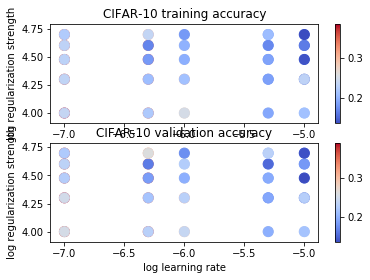

In [23]:
# Visualize the cross-validation results
import math

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [24]:
# Evaluate the best linear classifier on test set
y_test_pred = best.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear classifier on raw pixels final test set accuracy: %f' % test_accuracy)

linear classifier on raw pixels final test set accuracy: 0.363000


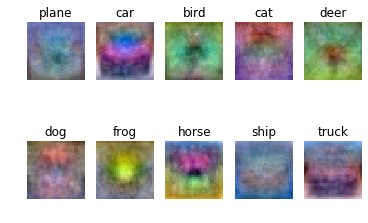

In [25]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized linear classifier weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in* It looks like weights optimized to a representitive version of the instances of that class, as the ship have blue sea and an object in the middle and frog have a green entity in the middle and terrain on the sides.
